In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

- `torchvision.datasets` 에서 데이터 로드
- 아래 링크에서 built-in datasets의 목록을 확인해 볼 수 있습니다.
  - [PyTorch Built-in Datsets](https://pytorch.org/vision/stable/datasets.html)

`torchvision`의 `Image Transform` 에 대하여 생소하다면 **다음의 링크를 참고**해 주시기 바랍니다.

- [torchvision의 transform으로 이미지 정규화하기(평균, 표준편차를 계산하여 적용](https://teddylee777.github.io/pytorch/torchvision-transform)
- [PyTorch 이미지 데이터셋(Image Dataset) 구성에 관한 거의 모든 것!](https://teddylee777.github.io/pytorch/dataset-dataloader)

In [2]:
# Image Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

`Fashion MNIST` 내장 데이터셋을 로드하여 실습을 진행합니다.

In [3]:
# train(학습용) 데이터셋 로드
train_data = datasets.FashionMNIST(root='data', 
                                   train=True,        # 학습용 데이터셋 설정(True)
                                   download=True, 
                                   transform=transform                
                                  )

In [4]:
# test(학습용) 데이터셋 로드
test_data = datasets.FashionMNIST(root='data', 
                                  train=False,        # 검증용 데이터셋 설정(False)
                                  download=True, 
                                  transform=transform
                                 )

`FashionMNIST` 데이터셋 시각화

- 총 10개의 카테고리로 구성되어 있으며, `Label`은 아래 코드에서 `labels_map`에 정의되어 있습니다.
- 출처: [zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

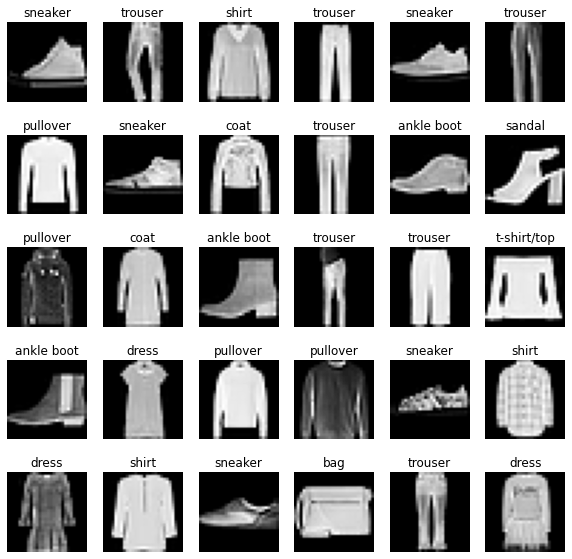

In [5]:
import matplotlib.pyplot as plt

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

## torch.utils.data.DataLoader

`DataLoader`는 배치 구성과 shuffle등을 편하게 구성해 주는 util 입니다.

In [6]:
batch_size = 32 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

In [8]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=False, 
                                          num_workers=num_workers)

`train_loader`의 1개 배치의 shape 출력

In [9]:
# 1개의 배치 추출 후 Image, label의 shape 출력
img, lbl = next(iter(train_loader))
img.shape, lbl.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

배치사이즈인 32가 가장 첫번째 dimension에 출력되고, 그 뒤로 채널, 세로, 가로 순서로 출력이 됩니다.

즉, greyscale 의 `28 X 28` 이미지 `32장`이 1개의 배치로 구성이 되어 있습니다.

## 모델 정의

CUDA 설정이 되어 있다면 `cuda`를! 그렇지 않다면 `cpu`로 학습합니다.

(제 PC에는 GPU가 2대 있어서 `cuda:0`로 GPU 장비의 index를 지정해 주었습니다. 만약 다른 장비를 사용하고 싶다면 `cuda:1` 이런식으로 지정해 주면 됩니다)

In [10]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


아래의 모델은 DNN으로 구성하였습니다. 추후, 모델 부분을 CNN이나 pre-trained model로 교체할 수 있습니다.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x     

In [12]:
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

DNNModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

## 훈련(Train)

In [14]:
from tqdm import tqdm  # Progress Bar 출력

In [15]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

## 평가(Evaluate)

In [16]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

## 모델 훈련(training) & 검증

In [17]:
# 최대 Epoch을 지정합니다.
num_epochs = 20

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100% 1875/1875 [00:04<00:00, 445.34it/s]


val_loss has been improved from inf to 0.42429. Saving Model!
epoch 01, loss: 0.55653, acc: 0.80107, val_loss: 0.42429, val_accuracy: 0.84950


100% 1875/1875 [00:04<00:00, 460.48it/s]


val_loss has been improved from 0.42429 to 0.38282. Saving Model!
epoch 02, loss: 0.37441, acc: 0.86393, val_loss: 0.38282, val_accuracy: 0.86280


100% 1875/1875 [00:04<00:00, 453.84it/s]


epoch 03, loss: 0.33538, acc: 0.87767, val_loss: 0.38931, val_accuracy: 0.86290


100% 1875/1875 [00:04<00:00, 455.05it/s]


val_loss has been improved from 0.38282 to 0.35129. Saving Model!
epoch 04, loss: 0.30863, acc: 0.88853, val_loss: 0.35129, val_accuracy: 0.86890


100% 1875/1875 [00:04<00:00, 447.22it/s]


val_loss has been improved from 0.35129 to 0.34075. Saving Model!
epoch 05, loss: 0.28994, acc: 0.89215, val_loss: 0.34075, val_accuracy: 0.87460


100% 1875/1875 [00:04<00:00, 450.35it/s]


epoch 06, loss: 0.27176, acc: 0.89980, val_loss: 0.36094, val_accuracy: 0.87150


100% 1875/1875 [00:04<00:00, 443.07it/s]


epoch 07, loss: 0.25868, acc: 0.90415, val_loss: 0.34475, val_accuracy: 0.87800


100% 1875/1875 [00:04<00:00, 447.50it/s]


val_loss has been improved from 0.34075 to 0.32414. Saving Model!
epoch 08, loss: 0.24608, acc: 0.90673, val_loss: 0.32414, val_accuracy: 0.88970


100% 1875/1875 [00:04<00:00, 448.74it/s]


epoch 09, loss: 0.23623, acc: 0.91130, val_loss: 0.32660, val_accuracy: 0.88340


100% 1875/1875 [00:04<00:00, 450.33it/s]


epoch 10, loss: 0.22619, acc: 0.91510, val_loss: 0.32550, val_accuracy: 0.88620


100% 1875/1875 [00:04<00:00, 450.43it/s]


epoch 11, loss: 0.21585, acc: 0.91827, val_loss: 0.33025, val_accuracy: 0.88710


100% 1875/1875 [00:04<00:00, 444.86it/s]


epoch 12, loss: 0.20716, acc: 0.92187, val_loss: 0.35040, val_accuracy: 0.88430


100% 1875/1875 [00:04<00:00, 441.60it/s]


epoch 13, loss: 0.19787, acc: 0.92447, val_loss: 0.35395, val_accuracy: 0.88630


100% 1875/1875 [00:04<00:00, 445.40it/s]


epoch 14, loss: 0.18987, acc: 0.92833, val_loss: 0.34877, val_accuracy: 0.88420


100% 1875/1875 [00:04<00:00, 450.62it/s]


epoch 15, loss: 0.18462, acc: 0.92942, val_loss: 0.32642, val_accuracy: 0.89690


100% 1875/1875 [00:04<00:00, 445.37it/s]


epoch 16, loss: 0.17759, acc: 0.93293, val_loss: 0.36149, val_accuracy: 0.88150


100% 1875/1875 [00:04<00:00, 446.42it/s]


epoch 17, loss: 0.17055, acc: 0.93517, val_loss: 0.33631, val_accuracy: 0.89640


100% 1875/1875 [00:04<00:00, 450.76it/s]


epoch 18, loss: 0.16626, acc: 0.93688, val_loss: 0.36313, val_accuracy: 0.89320


100% 1875/1875 [00:04<00:00, 452.99it/s]


epoch 19, loss: 0.15961, acc: 0.93843, val_loss: 0.38574, val_accuracy: 0.88100


100% 1875/1875 [00:04<00:00, 450.54it/s]


epoch 20, loss: 0.15411, acc: 0.94178, val_loss: 0.36963, val_accuracy: 0.89350


## 저장한 가중치 로드 후 검증 성능 측정

In [19]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

<All keys matched successfully>

In [23]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.32414, evaluation accuracy: 0.88970
